## <center> Go to piazza and open today's lecture notes in the hub! </center>
## <center> https://piazza.com/class/jzioyk40mhs6r2 </center>
## <center> Let's go to tophat for attendance! </center>
## <center> https://app.tophat.com/e/245218 </center>

## <center>Mud card</center>

- **I would like to receive more clarification about encoders from last lesson.**
   - you can read more [here](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features) and [here](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)
- **Why do you use a randomforestregreesor as an estimator in iterativeimputer? when do we leave the estimator to default?**
   - we will cover this later, but random forests are random 
       - for each random seed, a random forest will a select a different set of features and points to use to generate decision trees
   - some regressors are deterministic
       - there is no randomness in the way the model is constructed so they always return the same model
   - let's take a look at that example again!

In [1]:
# let's impute exercise1a.csv
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd

df = pd.read_csv('data/exercise1a.csv')

X = df[['feature 1','feature 2']].values
print(X[:10])

y = df['label'].values
imputer = IterativeImputer(estimator=LinearRegression(),random_state=1)
X_impute = imputer.fit_transform(X)

print(X_impute[:10])

[[ 1.01120706 -1.47656266]
 [-0.33128317  0.38653915]
 [ 1.2179409          nan]
 [ 0.98633519  0.2135339 ]
 [ 0.92550121 -0.45698786]
 [ 1.16033857  0.36949272]
 [-1.53879325         nan]
 [-1.55694156 -0.61244213]
 [-0.77785883  1.11584111]
 [-2.08639057         nan]]
[[ 1.01120706 -1.47656266]
 [-0.33128317  0.38653915]
 [ 1.2179409  -0.03055373]
 [ 0.98633519  0.2135339 ]
 [ 0.92550121 -0.45698786]
 [ 1.16033857  0.36949272]
 [-1.53879325  0.23576466]
 [-1.55694156 -0.61244213]
 [-0.77785883  1.11584111]
 [-2.08639057  0.28866611]]


## <center>MCAR test</center>

In [2]:
# from the pymice package 
# https://github.com/RianneSchouten/pymice

import numpy as np
import pandas as pd
import math as ma
import scipy.stats as st

def checks_input_mcar_tests(data):
    """ Checks whether the input parameter of class McarTests is correct
            Parameters
            ----------
            data:
                The input of McarTests specified as 'data'
            Returns
            -------
            bool
                True if input is correct
            """

    if not isinstance(data, pd.DataFrame):
        print("Error: Data should be a Pandas DataFrame")
        return False

    if not any(data.dtypes.values == np.float):
        if not any(data.dtypes.values == np.int):
            print("Error: Dataset cannot contain other value types than floats and/or integers")
            return False

    if not data.isnull().values.any():
        print("Error: No NaN's in given data")
        return False

    return True


def mcar_test(data):
    """ Implementation of Little's MCAR test
    Parameters
    ----------
    data: Pandas DataFrame
        An incomplete dataset with samples as index and variables as columns
    Returns
    -------
    p_value: Float
        This value is the outcome of a chi-square statistical test, testing whether the null hypothesis
        'the missingness mechanism of the incomplete dataset is MCAR' can be rejected.
    """

    if not checks_input_mcar_tests(data):
        raise Exception("Input not correct")

    dataset = data.copy()
    vars = dataset.dtypes.index.values
    n_var = dataset.shape[1]

    # mean and covariance estimates
    # ideally, this is done with a maximum likelihood estimator
    gmean = dataset.mean()
    gcov = dataset.cov()

    # set up missing data patterns
    r = 1 * dataset.isnull()
    mdp = np.dot(r, list(map(lambda x: ma.pow(2, x), range(n_var))))
    sorted_mdp = sorted(np.unique(mdp))
    n_pat = len(sorted_mdp)
    correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
    dataset['mdp'] = pd.Series(correct_mdp, index=dataset.index)

    # calculate statistic and df
    pj = 0
    d2 = 0
    for i in range(n_pat):
        dataset_temp = dataset.loc[dataset['mdp'] == i, vars]
        select_vars = ~dataset_temp.isnull().any()
        pj += np.sum(select_vars)
        select_vars = vars[select_vars]
        means = dataset_temp[select_vars].mean() - gmean[select_vars]
        select_cov = gcov.loc[select_vars, select_vars]
        mj = len(dataset_temp)
        parta = np.dot(means.T, np.linalg.solve(select_cov, np.identity(select_cov.shape[1])))
        d2 += mj * (np.dot(parta, means))

    df = pj - n_var

    # perform test and save output
    p_value = 1 - st.chi2.cdf(d2, df)

    return p_value

#df = pd.read_csv('data/exercise1a.csv')
df = pd.read_csv('data/MCAR.csv')

print(mcar_test(df))

0.4302966303100213


# Exploratory data analysis, part 1, EDA in regression and clustering
### By the end of this lecture, you will be able to
- Study the properties of a continuous feature or the target variable in isolation
- Study the interaction between the target variable and features
- Study the interaction between feature pairs


## <center> High-level overview </center>


| *Visualization types*        	|    target variable continuous    	| label categorical 	|     feature continuous     	|     feature categorical/ordinal    	|
|---------------------	|:----------------------:	|:-----------------:	|:--------------------------:	|:--------------------------:	|
| __target variable continuous__    	| histogram, .describe() 	|         ---         	|    scatter plot/heatmap    	|           boxplot          	|
| __label categorical__   	|            ---           	|  bar plot, dataset balance  	|           boxplot          	|        plt.matshow()       	|
| __feature continuous__  	|  scatter plot/heatmap  	|      boxplot      	| scatter/correlation matrix 	| scatter/correlation matrix 	|
| __feature categorical/ordinal__ 	|         boxplot        	|   plt.matshow()   	| scatter/correlation matrix 	| scatter/correlation matrix 	|

## Dataset of the day

House prices - regression dataset

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## Packages of the day

matplotlib and pandas

## Let's preprocess the dataset!

In [3]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Let's load the data
df = pd.read_csv('data/train.csv')
# drop the ID
df.drop(columns=['Id'],inplace=True)
print(df.shape)

# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

(1460, 80)


In [4]:
# preprocess feature types one by one

# one-hot encoder
ohe = OneHotEncoder(sparse=False)
si = SimpleImputer(strategy='constant',fill_value='missing')
cat_values = ohe.fit_transform(si.fit_transform(df[cat_ftrs]))
cat_ftr_names = ohe.get_feature_names()
df_cat = pd.DataFrame(data=cat_values,columns = cat_ftr_names)

# ordinal encoder
oe = OrdinalEncoder(categories = ordinal_cats)
si2 = SimpleImputer(strategy='constant',fill_value='NA')
oe_values = oe.fit_transform(si2.fit_transform(df[ordinal_ftrs]))
df_ordinal = pd.DataFrame(data=oe_values,columns = ordinal_ftrs)

# standard scaler
ss = StandardScaler()
num_values = ss.fit_transform(df[num_ftrs])
df_num = pd.DataFrame(data=num_values,columns = num_ftrs)

df_preprocessed = pd.concat([df_cat,df_ordinal,df_num],axis=1)
df_preprocessed['SalePrice'] = df['SalePrice']
print(df_preprocessed.shape)

(1460, 230)


In [22]:
# preprocess with pipeline and columntransformer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

# fit_transform the data
X_prep = preprocessor.fit_transform(df)
# little hacky, but collect feature names
feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['cat'][1].get_feature_names()) + \
                preprocessor.transformers_[2][-1]

df_preprocessed = pd.DataFrame(data=X_prep,columns=feature_names)
df_preprocessed['SalePrice'] = df['SalePrice']

print(df_preprocessed.shape)


(1460, 230)


### <font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- **Study the properties of a continuous feature or the target variable in isolation**
- <font color='LIGHTGRAY'>Study the interaction between the target variable and features</font>
- <font color='LIGHTGRAY'>Study the interaction between feature pairs</font>


### target variable or feature is continuous

In [6]:
# the target variable is 'SalePrice'
y = df['SalePrice']
print(y.describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


No sales price with 0 or negative values! YAY!

In [7]:
# histogram with pandas
# it uses a matplotlib backend but it is less customizable
# good for quick visualizations for exploration
# usually not enough for reporting/publication
y.hist(bins=30)


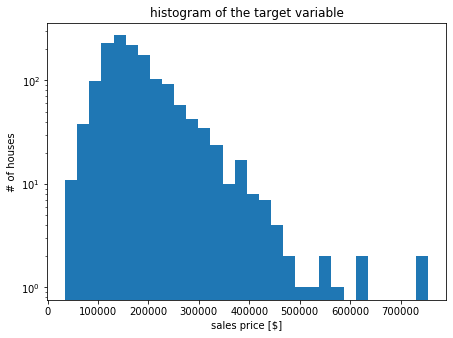

In [8]:
# matplotlib - customizable plots
import matplotlib
from matplotlib import pylab as plt

# matplotlib code structure

# define your canvas, e.g., figure size, number of subplots and their positions, etc
plt.figure(figsize=(6.4,4.8))

# draw on the figure, define the properties of the line or marker
plt.hist(y,bins=30,log=True)
#df['SalePrice'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('sales price [$]')
plt.ylabel('# of houses')
plt.title('histogram of the target variable')
plt.tight_layout()

# show the figure in the notebook or save it as a file
plt.savefig('figures/y_hist.png',dpi=300)
plt.show()

<center><img src="figures/y_hist.png" width="600"></center>

## Exercise 1

Describe and plot the histogram of the 'GrLivArea'.

In [9]:
# add your code here


### <font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Study the properties of a continuous feature or the target variable in isolation</font>
- **Study the interaction between the target variable and features**
- <font color='LIGHTGRAY'>Study the interaction between feature pairs</font>


Target variable is continuous today.

1) Feature is continuous as well:
- a) scatter plot
- b) heatmaps

2) Feature is categorical:
- a) boxplot
- b) histogram

### 1.a) Feature is continuous: scatter plot

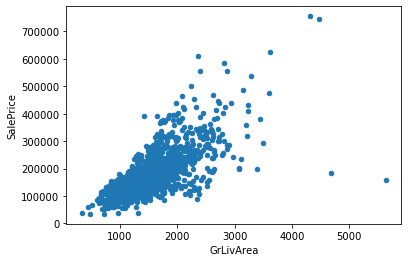

In [10]:
df.plot.scatter('GrLivArea','SalePrice') # the color and size of each point can also be defined
plt.savefig('figures/scatter.png',dpi=300)
plt.show()

### 1.b) Feature is continuous: heatmap

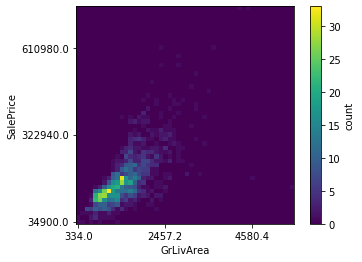

In [11]:
import numpy as np

heatmap, xedges, yedges = np.histogram2d(df['GrLivArea'], df['SalePrice'], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, origin='lower')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.xticks(np.arange(50)[::20],xedges[::20])
plt.yticks(np.arange(50)[::20],yedges[::20])
plt.colorbar(label='count')
plt.savefig('figures/heatmap.png',dpi=300)
plt.show()

## 2.a) Feature is categorical: boxplot

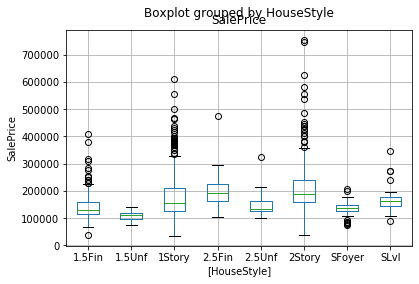

In [12]:
df[['SalePrice','HouseStyle']].boxplot(by='HouseStyle')
plt.ylabel('SalePrice')
plt.savefig('figures/boxplot.png',dpi=300)
plt.show()

## 2.b) Feature is categorical: histogram

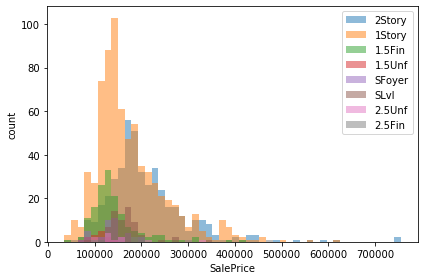

In [13]:
categories = df['HouseStyle'].unique()
bin_range = (df['SalePrice'].min(),df['SalePrice'].max())

for c in categories:
    plt.hist(df[df['HouseStyle']==c]['SalePrice'],alpha=0.5,label=c,range=bin_range,bins=50)
plt.legend()
plt.ylabel('count')
plt.xlabel('SalePrice')
plt.tight_layout()
plt.savefig('figures/histo.png',dpi=300)
plt.show()



## Exercise 2

### What plot type would you use?

- Neighborhood vs. SalePrice
- YearBuilt vs SalePrice
- OverallQual vs SalePrice

### <font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Study the properties of a continuous feature or the target variable in isolation</font>
- <font color='LIGHTGRAY'>Study the interaction between the target variable and features</font>
- **Study the interaction between feature pairs**


## Feature interactions: the correlation matrix

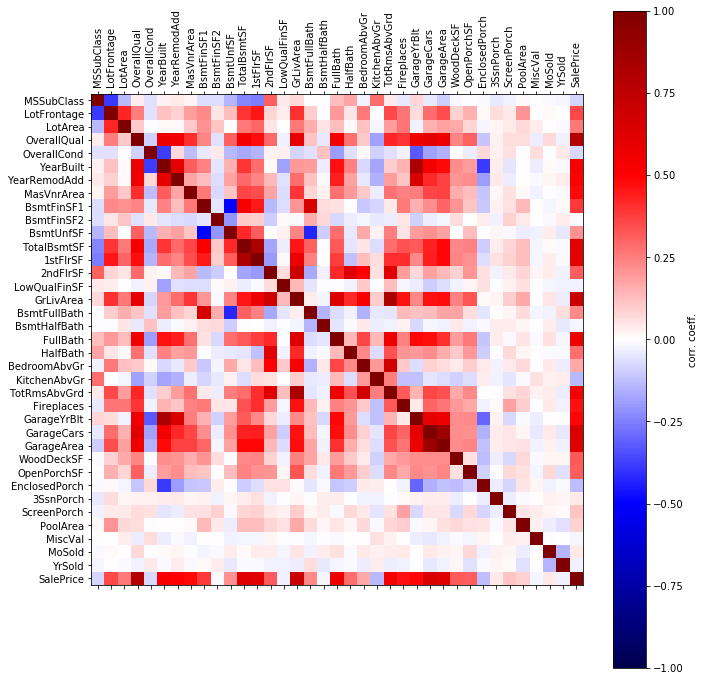

37


In [14]:
# df is used here! only the numerical columns are shown!
plt.figure(figsize=(10,10))
plt.matshow(df.corr(),vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(df.corr().shape[0]),list(df.corr().columns),rotation=90)
plt.yticks(np.arange(df.corr().shape[0]),list(df.corr().columns))
plt.tight_layout()
plt.savefig('figures/corr_coeff.png',dpi=300)
plt.show()

print(df.corr().shape[0])

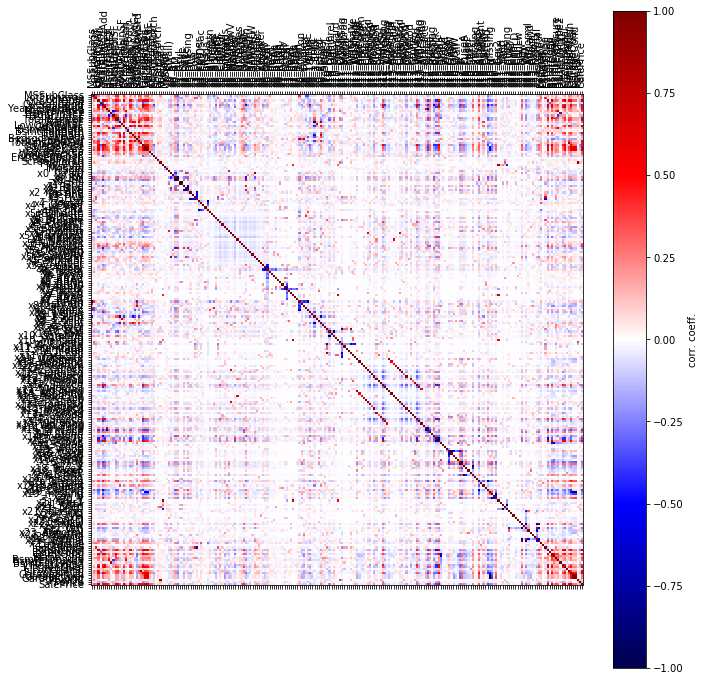

In [15]:
plt.figure(figsize=(10,10))
plt.matshow(df_preprocessed.corr(),vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(df_preprocessed.corr().shape[0]),list(df_preprocessed.corr().columns),rotation=90)
plt.yticks(np.arange(df_preprocessed.corr().shape[0]),list(df_preprocessed.corr().columns))
plt.tight_layout()
plt.savefig('figures/corr_coeff_dummies.png',dpi=300)
plt.show()

# too many features! let's sort them!

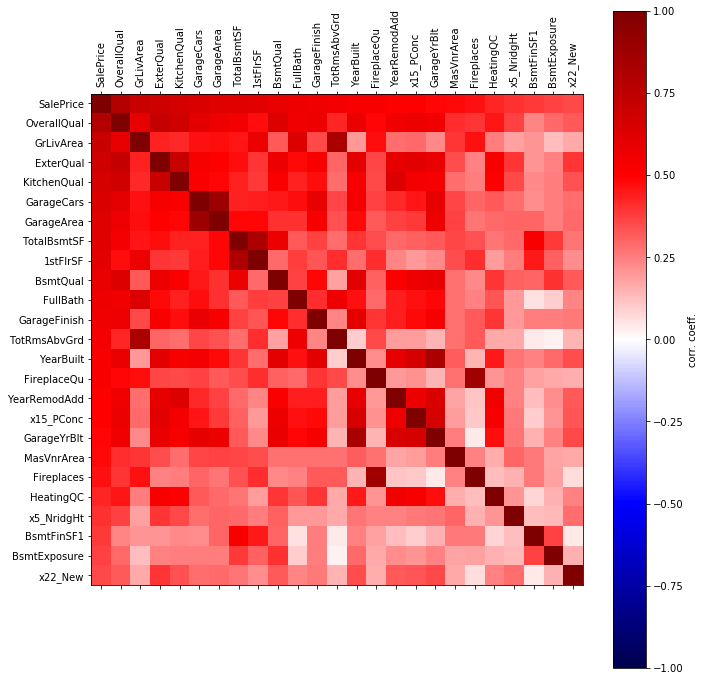

In [16]:
corrmat = df_preprocessed.corr()

all_cols = corrmat.sort_values('SalePrice',ascending=False)['SalePrice'].index 
cols = all_cols[:25] # positively correlated features

cm = corrmat.loc[cols,cols]

plt.figure(figsize=(10,10))
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.tight_layout()
plt.savefig('figures/corr_coeff_dummies.png',dpi=300)
plt.show()

### Don't forget about strong negative correlations! 
### Those are predictive too!

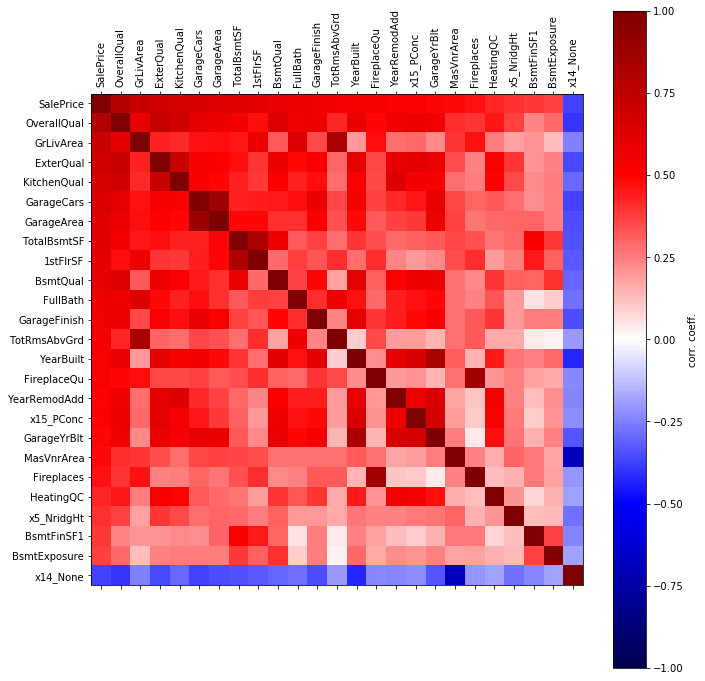

In [17]:
corrmat = df_preprocessed.corr()

# use the absolute value of the correlation matrix for sorting!
all_cols = np.abs(corrmat).sort_values('SalePrice',ascending=False)['SalePrice'].index 
cols = all_cols[:25] # positively correlated features

cm = corrmat.loc[cols,cols]

plt.figure(figsize=(10,10))
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.tight_layout()
plt.savefig('figures/abs_corr_coeff_dummies.png',dpi=300)
plt.show()

## Feature interactions: pair plot aka. scatter matrix

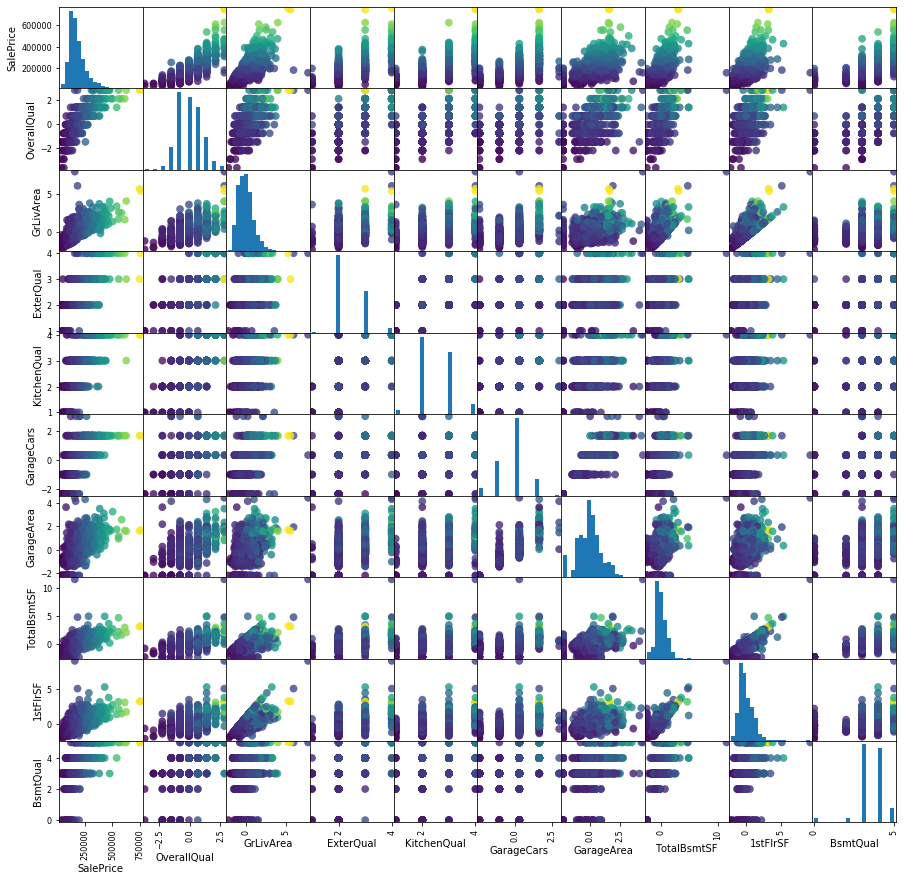

In [18]:
corrmat = df_preprocessed.corr()

all_cols = corrmat.sort_values('SalePrice',ascending=False)['SalePrice'].index 
cols = all_cols[:10] # positively correlated features
#cols = ['SalePrice']+[col for col in all_cols if '_nan' not in col][:-10:-1] # negatively correlated features

pd.plotting.scatter_matrix(df_preprocessed[cols],c = df_preprocessed['SalePrice'], figsize=(15, 15), marker='o',
                           hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.savefig('figures/scatter_matrix_dummies.png',dpi=300)
plt.show()

### Now you can</font>
- Study the properties of a continuous feature or the target variable in isolation
- Study the interaction between the target variable and features
- Study the interaction between feature pairs
